In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from scipy import stats
from matplotlib.gridspec import GridSpec

In [2]:
def unique_non_null(s):
    return s.dropna().unique()

In [3]:
path = "./cbb.csv"
df = pd.read_csv(path)
df.head()

TEAM CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D   TOR  \
0  North Carolina  ACC  40  33  123.3   94.9   0.9531   52.6   48.1  15.4   
1       Wisconsin  B10  40  36  129.1   93.6   0.9758   54.8   47.7  12.4   
2        Michigan  B10  40  33  114.4   90.4   0.9375   53.9   47.7  14.0   
3      Texas Tech  B12  38  31  115.2   85.2   0.9696   53.5   43.0  17.7   
4         Gonzaga  WCC  39  37  117.8   86.3   0.9728   56.6   41.1  16.2   

   ...  FTRD  2P_O  2P_D  3P_O  3P_D  ADJ_T   WAB  POSTSEASON  SEED  YEAR  
0  ...  30.4  53.9  44.6  32.7  36.2   71.7   8.6         2ND   1.0  2016  
1  ...  22.4  54.8  44.7  36.5  37.5   59.3  11.3         2ND   1.0  2015  
2  ...  30.0  54.7  46.8  35.2  33.2   65.9   6.9         2ND   3.0  2018  
3  ...  36.6  52.8  41.9  36.5  29.7   67.5   7.0         2ND   3.0  2019  
4  ...  26.9  56.3  40.0  38.2  29.0   71.5   7.7         2ND   1.0  2017  

[5 rows x 24 columns]

In [5]:
df["TEAM"].unique()

array(['North Carolina', 'Wisconsin', 'Michigan', 'Texas Tech', 'Gonzaga',
       'Kentucky', 'Duke', 'Virginia', 'Villanova', 'Connecticut',
       'Louisville', 'Notre Dame', 'Florida St.', 'Purdue', 'Kansas',
       'Kansas St.', 'Xavier', 'Arizona', 'Oregon', 'Florida',
       'Michigan St.', 'Dayton', 'Ohio St.', 'Marquette', 'Syracuse',
       'Oklahoma', 'Loyola Chicago', 'South Carolina', 'Auburn',
       'Wichita St.', 'Duquesne', 'Fordham', 'George Mason',
       'George Washington', 'La Salle', 'Massachusetts', 'Rhode Island',
       'Richmond', "Saint Joseph's", 'Saint Louis', 'St. Bonaventure',
       'Davidson', 'VCU', 'Boston College', 'Clemson', 'Georgia Tech',
       'Miami FL', 'Pittsburgh', 'Virginia Tech', 'Wake Forest',
       'North Carolina St.', 'Binghamton', 'Hartford', 'Maine',
       'New Hampshire', 'Stony Brook', 'UMass Lowell', 'UMBC', 'Vermont',
       'Albany', 'East Carolina', 'Houston', 'Memphis', 'South Florida',
       'Temple', 'Tulane', 'Tulsa', 'U

In [6]:
# Offense stats
off_stats = ['ADJOE', 'EFG_O', 'TOR', 'ORB', 'FTR', 'ADJ_T']

In [7]:

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


In [43]:
# Get team stats from one year in ACC
acc = df[df['CONF'] == 'ACC']
acc = acc.sort_values(by='YEAR', ascending=False)
acc_2024 = acc[acc['YEAR'] == 2024]
acc_2024

TEAM CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D  \
3722          Louisville  ACC  32   8  104.2  106.9   0.4270   48.4   54.6   
3603       Virginia Tech  ACC  32  18  116.0  101.9   0.8166   54.1   51.5   
3526      North Carolina  ACC  34  27  116.8   93.2   0.9305   51.3   46.4   
3536                Duke  ACC  32  24  120.8   96.8   0.9272   55.2   49.0   
3545             Clemson  ACC  32  21  116.7   99.3   0.8647   53.9   48.7   
3564            Virginia  ACC  33  23  104.6   92.0   0.8147   49.3   46.2   
3567  North Carolina St.  ACC  36  22  114.0  101.2   0.7981   50.7   50.5   
3595          Pittsburgh  ACC  33  22  115.8   98.9   0.8600   51.6   49.0   
3593         Wake Forest  ACC  33  20  116.5   99.0   0.8660   54.7   48.9   
3621            Syracuse  ACC  31  20  111.2  100.8   0.7563   51.3   52.8   
3626      Boston College  ACC  34  19  111.8  102.0   0.7427   52.7   50.4   
3627         Florida St.  ACC  33  17  110.1  100.7   0.7372   50.3   52.2   
3632            Miami FL  ACC  32  15  109.9  101.1   0.7241   52.7   51.0   
3659        Georgia Tech  ACC  32  14  107.9  103.8   0.6095   48.7   49.2   
3663          Notre Dame  ACC  33  13  101.9   98.2   0.6052   47.6   48.2   

       TOR  ...  FTRD  2P_O  2P_D  3P_O  3P_D  ADJ_T    WAB  POSTSEASON  SEED  \
3722  18.1  ...  33.8  49.4  53.8  30.6  37.2   69.5 -12.50         NaN   NaN   
3603  16.3  ...  30.0  55.1  51.5  35.1  34.4   67.5  -2.20         NaN   NaN   
3526  14.4  ...  28.3  50.3  46.0  35.4  31.4   70.4   6.60         S16   1.0   
3536  14.3  ...  27.6  54.4  49.1  37.7  32.6   66.9   3.30          E8   4.0   
3545  14.9  ...  31.2  54.4  47.1  35.4  34.0   66.2   0.90          E8   6.0   
3564  13.2  ...  25.7  46.8  46.6  36.3  30.4   60.0   1.20         R68  10.0   
3567  13.7  ...  31.9  50.1  49.5  34.6  34.9   67.9  -0.60          F4  11.0   
3595  13.4  ...  30.5  50.0  50.8  35.7  30.8   65.8   0.30         NaN   NaN   
3593  15.6  ...  30.7  54.0  48.8  37.2  32.6   68.0  -1.30         NaN   NaN   
3621  15.9  ...  26.6  51.9  53.2  33.4  34.7   70.7  -0.26         NaN   NaN   
3626  15.5  ...  28.4  51.8  49.5  36.1  34.6   67.1  -3.60         NaN   NaN   
3627  16.4  ...  41.0  51.5  51.6  31.7  35.4   70.9  -3.50         NaN   NaN   
3632  17.2  ...  22.3  51.6  52.0  36.1  33.3   68.7  -5.30         NaN   NaN   
3659  17.7  ...  31.6  48.6  49.5  32.6  32.6   67.4  -5.70         NaN   NaN   
3663  19.1  ...  27.4  47.5  47.8  31.8  32.5   64.2  -7.80         NaN   NaN   

      YEAR  
3722  2024  
3603  2024  
3526  2024  
3536  2024  
3545  2024  
3564  2024  
3567  2024  
3595  2024  
3593  2024  
3621  2024  
3626  2024  
3627  2024  
3632  2024  
3659  2024  
3663  2024  

[15 rows x 24 columns]

In [9]:
top5df = acc_2024.head()
top5df

TEAM CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D  \
3526      North Carolina  ACC  34  27  116.8   93.2   0.9305   51.3   46.4   
3536                Duke  ACC  32  24  120.8   96.8   0.9272   55.2   49.0   
3545             Clemson  ACC  32  21  116.7   99.3   0.8647   53.9   48.7   
3564            Virginia  ACC  33  23  104.6   92.0   0.8147   49.3   46.2   
3567  North Carolina St.  ACC  36  22  114.0  101.2   0.7981   50.7   50.5   

       TOR  ...  FTRD  2P_O  2P_D  3P_O  3P_D  ADJ_T  WAB  POSTSEASON  SEED  \
3526  14.4  ...  28.3  50.3  46.0  35.4  31.4   70.4  6.6         S16   1.0   
3536  14.3  ...  27.6  54.4  49.1  37.7  32.6   66.9  3.3          E8   4.0   
3545  14.9  ...  31.2  54.4  47.1  35.4  34.0   66.2  0.9          E8   6.0   
3564  13.2  ...  25.7  46.8  46.6  36.3  30.4   60.0  1.2         R68  10.0   
3567  13.7  ...  31.9  50.1  49.5  34.6  34.9   67.9 -0.6          F4  11.0   

      YEAR  
3526  2024  
3536  2024  
3545  2024  
3564  2024  
3567  2024  

[5 rows x 24 columns]

In [148]:
agg_acc = df.groupby(['TEAM']).agg({
    'ADJ_T': ['var', 'median', 'mean', 'max', 'min'],
    'EFG_D': ['var', 'median', 'mean', 'max', 'min'],
    'TORD': ['var', 'median', 'mean', 'max', 'min'],
    'DRB': ['var', 'median', 'mean', 'max', 'min'],
    'ORB': ['var', 'median', 'mean', 'max', 'min'],
    'TOR': ['var', 'median', 'mean', 'max', 'min'],
    'EFG_O': ['var', 'median', 'mean', 'max', 'min']
})
agg_teams = agg_acc.rank(pct=True)
agg_teams

ADJ_T                                             EFG_D  \
                        var    median      mean       max       min       var   
TEAM                                                                            
Abilene Christian  0.343324  0.682927  0.563686  0.319783  0.562331  0.956403   
Air Force          0.572207  0.027100  0.035230  0.085366  0.172087  0.528610   
Akron              0.326975  0.218157  0.195122  0.132791  0.204607  0.852861   
Alabama            0.975477  0.888889  0.657182  0.865854  0.184282  0.664850   
Alabama A&M        0.122616  0.237127  0.284553  0.340108  0.457995  0.964578   
...                     ...       ...       ...       ...       ...       ...   
Wright St.         0.820163  0.735772  0.569106  0.520325  0.399729  0.893733   
Wyoming            0.991826  0.120596  0.249322  0.902439  0.025745  0.869210   
Xavier             0.752044  0.668022  0.677507  0.666667  0.376694  0.128065   
Yale               0.784741  0.192412  0.341463  0.635501  0.294038  0.392371   
Youngstown St.     0.498638  0.693767  0.818428  0.791328  0.903794  0.850136   

                                                           ...       TOR  \
                     median      mean       max       min  ...       var   
TEAM                                                       ...             
Abilene Christian  0.883469  0.905149  0.890244  0.294038  ...  0.482289   
Air Force          0.925474  0.943089  0.943089  0.861789  ...  0.261580   
Akron              0.200542  0.143631  0.604336  0.200542  ...  0.392371   
Alabama            0.044715  0.035230  0.042005  0.008130  ...  0.179837   
Alabama A&M        0.432249  0.403794  0.577236  0.116531  ...  0.523161   
...                     ...       ...       ...       ...  ...       ...   
Wright St.         0.529810  0.491870  0.779133  0.246612  ...  0.294278   
Wyoming            0.494580  0.421409  0.471545  0.444444  ...  0.068120   
Xavier             0.387534  0.321138  0.155827  0.520325  ...  0.256131   
Yale               0.329268  0.295393  0.285908  0.520325  ...  0.828338   
Youngstown St.     0.925474  0.902439  0.979675  0.817073  ...  0.177112   

                                                              EFG_O            \
                     median      mean       max       min       var    median   
TEAM                                                                            
Abilene Christian  0.728997  0.696477  0.699187  0.838753  0.446866  0.478320   
Air Force          0.674797  0.787263  0.738482  0.936314  0.596730  0.749322   
Akron              0.178862  0.322493  0.379404  0.371274  0.174387  0.779133   
Alabama            0.775068  0.673442  0.271003  0.531165  0.465940  0.684282   
Alabama A&M        0.981030  0.972900  0.932249  0.894309  0.188011  0.010840   
...                     ...       ...       ...       ...       ...       ...   
Wright St.         0.355014  0.424119  0.271003  0.663957  0.765668  0.760163   
Wyoming            0.279133  0.292683  0.172087  0.502710  0.049046  0.850949   
Xavier             0.201897  0.269648  0.271003  0.476965  0.305177  0.826558   
Yale               0.692412  0.527100  0.673442  0.116531  0.836512  0.867209   
Youngstown St.     0.096206  0.093496  0.104336  0.371274  0.245232  0.439024   

                                                 
                       mean       max       min  
TEAM                                             
Abilene Christian  0.460705  0.409214  0.608401  
Air Force          0.795393  0.705962  0.764228  
Akron              0.800813  0.765583  0.845528  
Alabama            0.714092  0.873984  0.806233  
Alabama A&M        0.013550  0.016260  0.037940  
...                     ...       ...       ...  
Wright St.         0.837398  0.972900  0.890244  
Wyoming            0.826558  0.523035  0.929539  
Xavier             0.867209  0.849593  0.921409  
Yale               0.750678  0.818428  0.510840  
Youngstown St.     0.573171  0.705962

In [155]:
invert_cols = ['TOR', 'EFG_D', 'DRB']

for stat in invert_cols:
    agg_teams[stat] = 1 - agg_teams[stat]

agg_teams

ADJ_T                                             EFG_D  \
                        var    median      mean       max       min       var   
TEAM                                                                            
Abilene Christian  0.343324  0.682927  0.563686  0.319783  0.562331  0.043597   
Air Force          0.572207  0.027100  0.035230  0.085366  0.172087  0.471390   
Akron              0.326975  0.218157  0.195122  0.132791  0.204607  0.147139   
Alabama            0.975477  0.888889  0.657182  0.865854  0.184282  0.335150   
Alabama A&M        0.122616  0.237127  0.284553  0.340108  0.457995  0.035422   
...                     ...       ...       ...       ...       ...       ...   
Wright St.         0.820163  0.735772  0.569106  0.520325  0.399729  0.106267   
Wyoming            0.991826  0.120596  0.249322  0.902439  0.025745  0.130790   
Xavier             0.752044  0.668022  0.677507  0.666667  0.376694  0.871935   
Yale               0.784741  0.192412  0.341463  0.635501  0.294038  0.607629   
Youngstown St.     0.498638  0.693767  0.818428  0.791328  0.903794  0.149864   

                                                           ...       TOR  \
                     median      mean       max       min  ...       var   
TEAM                                                       ...             
Abilene Christian  0.116531  0.094851  0.109756  0.705962  ...  0.517711   
Air Force          0.074526  0.056911  0.056911  0.138211  ...  0.738420   
Akron              0.799458  0.856369  0.395664  0.799458  ...  0.607629   
Alabama            0.955285  0.964770  0.957995  0.991870  ...  0.820163   
Alabama A&M        0.567751  0.596206  0.422764  0.883469  ...  0.476839   
...                     ...       ...       ...       ...  ...       ...   
Wright St.         0.470190  0.508130  0.220867  0.753388  ...  0.705722   
Wyoming            0.505420  0.578591  0.528455  0.555556  ...  0.931880   
Xavier             0.612466  0.678862  0.844173  0.479675  ...  0.743869   
Yale               0.670732  0.704607  0.714092  0.479675  ...  0.171662   
Youngstown St.     0.074526  0.097561  0.020325  0.182927  ...  0.822888   

                                                              EFG_O            \
                     median      mean       max       min       var    median   
TEAM                                                                            
Abilene Christian  0.271003  0.303523  0.300813  0.161247  0.446866  0.478320   
Air Force          0.325203  0.212737  0.261518  0.063686  0.596730  0.749322   
Akron              0.821138  0.677507  0.620596  0.628726  0.174387  0.779133   
Alabama            0.224932  0.326558  0.728997  0.468835  0.465940  0.684282   
Alabama A&M        0.018970  0.027100  0.067751  0.105691  0.188011  0.010840   
...                     ...       ...       ...       ...       ...       ...   
Wright St.         0.644986  0.575881  0.728997  0.336043  0.765668  0.760163   
Wyoming            0.720867  0.707317  0.827913  0.497290  0.049046  0.850949   
Xavier             0.798103  0.730352  0.728997  0.523035  0.305177  0.826558   
Yale               0.307588  0.472900  0.326558  0.883469  0.836512  0.867209   
Youngstown St.     0.903794  0.906504  0.895664  0.628726  0.245232  0.439024   

                                                 
                       mean       max       min  
TEAM                                             
Abilene Christian  0.460705  0.409214  0.608401  
Air Force          0.795393  0.705962  0.764228  
Akron              0.800813  0.765583  0.845528  
Alabama            0.714092  0.873984  0.806233  
Alabama A&M        0.013550  0.016260  0.037940  
...                     ...       ...       ...  
Wright St.         0.837398  0.972900  0.890244  
Wyoming            0.826558  0.523035  0.929539  
Xavier             0.867209  0.849593  0.921409  
Yale               0.750678  0.818428  0.510840  
Youngstown St.     0.573171  0.705962

In [156]:
agg_teams.loc['Pittsburgh']

ADJ_T  var       0.719346
       median    0.163957
       mean      0.086721
       max       0.109756
       min       0.055556
EFG_D  var       0.542234
       median    0.527100
       mean      0.714092
       max       0.769648
       min       0.799458
TORD   var       0.779292
       median    0.132791
       mean      0.268293
       max       0.624661
       min       0.215447
DRB    var       0.158038
       median    0.563686
       mean      0.588076
       max       0.289973
       min       0.796748
ORB    var       0.942779
       median    0.868564
       mean      0.905149
       max       0.972900
       min       0.352304
TOR    var       0.136240
       median    0.742547
       mean      0.742547
       max       0.536585
       min       0.959350
EFG_O  var       0.215259
       median    0.684282
       mean      0.521680
       max       0.336043
       min       0.593496
Name: Pittsburgh, dtype: float64

In [163]:
conf_aggregate = df.groupby(['CONF']).agg({
    'ADJ_T': ['var', 'median', 'mean', 'max', 'min'],
    'EFG_D': ['var', 'median', 'mean', 'max', 'min'],
    'TORD': ['var', 'median', 'mean', 'max', 'min'],
    'DRB': ['var', 'median', 'mean', 'max', 'min'],
    'ORB': ['var', 'median', 'mean', 'max', 'min'],
    'TOR': ['var', 'median', 'mean', 'max', 'min'],
    'EFG_O': ['var', 'median', 'mean', 'max', 'min']
})
conf_aggregate = conf_aggregate.rank(pct=True)
invert_cols = ['TOR', 'EFG_D', 'DRB']

for stat in invert_cols:
    conf_aggregate[stat] = 1 - conf_aggregate[stat]

acc_aggregate = conf_aggregate.loc['ACC']
acc_aggregate

ADJ_T  var       0.852941
       median    0.371429
       mean      0.228571
       max       0.685714
       min       0.085714
EFG_D  var       0.617647
       median    0.814286
       mean      0.800000
       max       0.714286
       min       0.771429
TORD   var       0.382353
       median    0.271429
       mean      0.228571
       max       0.228571
       min       0.271429
DRB    var       0.205882
       median    0.528571
       mean      0.571429
       max       0.471429
       min       0.771429
ORB    var       0.735294
       median    0.842857
       mean      0.914286
       max       0.842857
       min       0.600000
TOR    var       0.588235
       median    0.957143
       mean      0.942857
       max       0.900000
       min       0.785714
EFG_O  var       0.382353
       median    0.942857
       mean      0.914286
       max       0.742857
       min       0.842857
Name: ACC, dtype: float64

In [158]:
acc.groupby(['TEAM']).agg({
    'BARTHAG': ['mean']
}).sort_values(by=('BARTHAG', 'mean'))

BARTHAG
                        mean
TEAM                        
Boston College      0.616136
Georgia Tech        0.697982
Wake Forest         0.703491
Pittsburgh          0.711990
Louisville          0.744222
Virginia Tech       0.758418
Florida St.         0.767418
Notre Dame          0.772080
North Carolina St.  0.789836
Miami FL            0.817818
Clemson             0.818445
Syracuse            0.820430
Maryland            0.824550
Virginia            0.910445
North Carolina      0.917164
Duke                0.936736

In [159]:
teams = ['Duke', 'North Carolina', 'Virginia', 'Syracuse', 'Clemson']
top_team_agg = agg_teams.loc[teams].mean()
top_team_agg

ADJ_T  var       0.394005
       median    0.408672
       mean      0.390244
       max       0.453659
       min       0.383198
EFG_D  var       0.559128
       median    0.917073
       mean      0.916260
       max       0.850678
       min       0.860434
TORD   var       0.562398
       median    0.513550
       mean      0.516260
       max       0.508672
       min       0.388347
DRB    var       0.462670
       median    0.664499
       mean      0.628455
       max       0.588618
       min       0.625745
ORB    var       0.643597
       median    0.685095
       mean      0.747425
       max       0.763686
       min       0.650407
TOR    var       0.650681
       median    0.861518
       mean      0.913008
       max       0.884282
       min       0.834688
EFG_O  var       0.336785
       median    0.751762
       mean      0.765041
       max       0.650407
       min       0.779133
dtype: float64

In [109]:
top_team_agg = acc.head().sort_values(by='BARTHAG').groupby(['CONF']).agg({
    'ADJ_T': ['var', 'median', 'mean', 'max', 'min'],
    'EFG_D': ['var', 'median', 'mean', 'max', 'min'],
    'TORD': ['var', 'median', 'mean', 'max', 'min'],
    'DRB': ['var', 'median', 'mean', 'max', 'min'],
    'ORB': ['var', 'median', 'mean', 'max', 'min'],
    'TOR': ['var', 'median', 'mean', 'max', 'min'],
    'EFG_O': ['var', 'median', 'mean', 'max', 'min']
})
top_team_agg

ADJ_T                           EFG_D                            ...  \
        var median  mean   max   min    var median   mean   max   min  ...   
CONF                                                                   ...   
ACC   3.165   67.5  68.1  70.4  66.2  9.763   49.0  50.04  54.6  46.4  ...   

       TOR                           EFG_O                            
       var median  mean   max   min    var median   mean   max   min  
CONF                                                                  
ACC   2.59   14.9  15.6  18.1  14.3  7.507   53.9  52.58  55.2  48.4  

[1 rows x 35 columns]

In [48]:
cmap = plt.get_cmap("tab10")

def formatData(dataframe, input_stats, col):
    data = []
    for team in dataframe[col].unique():
        temp = dataframe[dataframe[col] == team]
        stats = []
        for stat in input_stats:
            stats.append(normalize(df, temp[stat], stat))
        data.append(stats)
    return data


def normalize(df, val, col):
    return (val - df[col].min())/(df[col].max() - df[col].min())


def radar_graph(df, stats, breakdown, title, labels=None, ax=None):
    N = len(stats)
    theta = radar_factory(N, frame='polygon')

    data = formatData(df, stats, breakdown)
    if labels is None:
        spoke_labels = stats
    else:
        spoke_labels = labels

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                                subplot_kw=dict(projection='radar'))
        fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
        fig.text(0.5, 0.965, title,
                horizontalalignment='center', color='black', weight='bold',
                size='large')

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate Axes
    #for ax, (title, case_data) in zip(axs.flat, data):
        # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    # ax.set_title('ACC Top 5', weight='bold', size='medium', position=(0.5, 1.1),
                    #horizontalalignment='center', verticalalignment='center')
    
    for i in range(len(data)):
        ax.plot(theta, data[i], color=cmap(i))
        ax.fill(theta, data[i], facecolor=cmap(i), alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = df[breakdown].unique()
    legend = ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')

    

    plt.show()

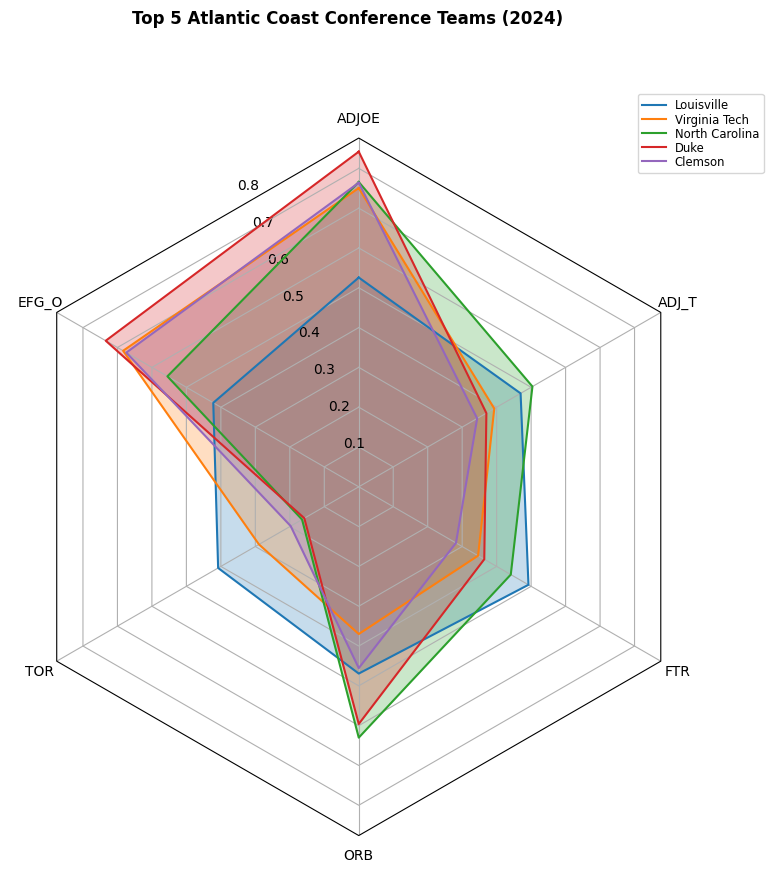

In [49]:
radar_graph(acc_2024.head(), off_stats, 'TEAM', 'Top 5 Atlantic Coast Conference Teams (2024)')

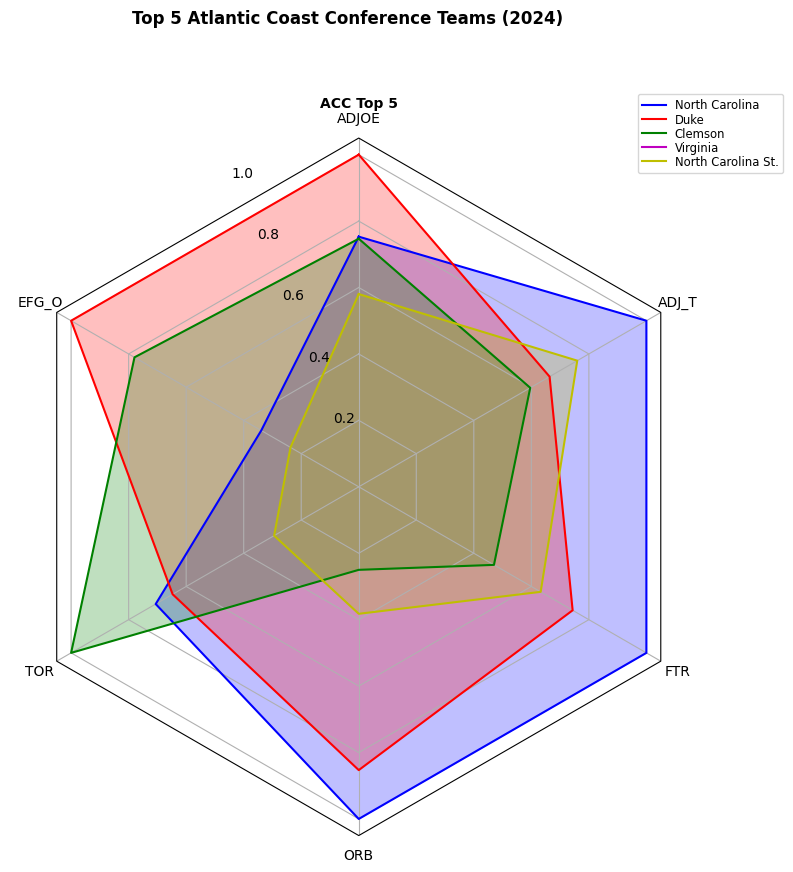

In [ ]:
N = 6
theta = radar_factory(N, frame='polygon')

data = formatData(acc_2024.head(), 'TEAM')
spoke_labels = off_stats

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate Axes
#for ax, (title, case_data) in zip(axs.flat, data):
    # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title('ACC Top 5', weight='bold', size='medium', position=(0.5, 1.1),
                horizontalalignment='center', verticalalignment='center')
for d, color in zip(data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels = acc_2024.head()['TEAM'].unique()
legend = ax.legend(labels, loc=(0.9, .95),
                            labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, 'Top 5 Atlantic Coast Conference Teams (2024)',
            horizontalalignment='center', color='black', weight='bold',
            size='large')

plt.show()

In [12]:
# For each unique team name in get conf that it had most and average of statistics between all years.
# ['ADJOE', 'EFG_O', 'TOR', 'ORB', 'FTR', 'ADJ_T']

conference_averages = df[df['YEAR'] == 2024].groupby(['CONF'], as_index=False)
agg_conf = conference_averages.agg({'ADJOE': 'median', 'EFG_O': 'median', 'TOR': 'median', 'ORB': 'median', 'FTR': 'median', 'ADJ_T': 'median'})
agg_conf

CONF   ADJOE  EFG_O    TOR    ORB    FTR  ADJ_T
0    A10  106.80  51.50  16.80  28.30  34.20  66.80
1    ACC  111.80  51.30  15.60  28.40  31.50  67.50
2     AE  101.30  50.40  16.70  25.50  29.90  69.70
3   ASun  103.75  50.65  15.90  27.95  31.75  67.40
4   Amer  108.85  50.65  16.45  31.90  34.90  67.80
5    B10  114.75  52.25  15.80  30.35  33.70  67.50
6    B12  113.55  51.90  17.55  32.05  34.85  67.25
7     BE  111.60  50.90  15.70  27.10  32.00  67.70
8   BSky  102.70  52.10  16.75  24.65  32.00  67.15
9   BSth  104.00  50.80  17.10  27.90  37.30  67.00
10    BW  103.50  48.90  18.30  28.60  37.60  66.80
11   CAA  104.50  50.60  16.15  28.30  30.45  66.80
12  CUSA  101.10  48.60  18.80  28.50  34.70  66.20
13  Horz  103.10  50.60  17.30  30.00  31.00  67.30
14   Ivy  107.40  52.10  17.50  27.55  29.00  66.35
15  MAAC  101.50  50.00  18.40  30.20  29.80  67.20
16   MAC  101.30  50.25  17.20  28.45  32.00  67.30
17  MEAC   97.30  46.70  20.60  31.25  38.15  67.40
18   MVC  107.75  51.10  16.60  24.95  30.90  67.80
19   MWC  111.50  51.50  16.00  28.50  34.00  66.10
20   NEC   95.40  47.20  17.20  25.90  31.70  67.40
21   OVC   97.10  47.20  17.80  27.50  32.80  67.40
22   P12  111.40  51.95  16.25  28.65  32.70  68.25
23   Pat   98.15  48.65  17.40  26.25  28.70  65.55
24    SB  103.45  49.75  16.65  29.75  32.40  68.25
25    SC  106.60  51.90  17.00  29.35  29.30  66.80
26   SEC  114.00  51.35  15.75  31.55  36.55  68.80
27  SWAC   96.55  47.05  19.45  28.75  36.25  67.90
28  Slnd   97.95  47.95  18.50  29.90  36.75  67.90
29   Sum  103.10  51.80  15.00  24.70  30.40  67.30
30   WAC  101.20  49.40  18.10  29.40  38.70  68.50
31   WCC  107.90  51.60  16.80  29.30  31.60  67.60
32   ind   96.60  45.70  20.50  32.20  38.90  65.20

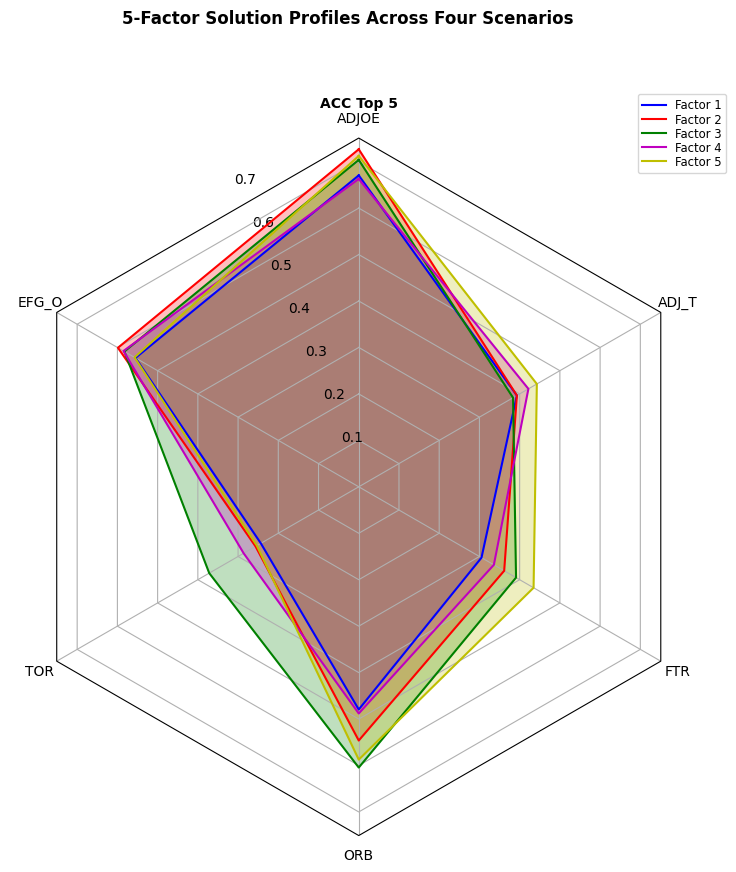

In [13]:
N = 6
theta = radar_factory(N, frame='polygon')

power5 = ['ACC', 'B10', 'B12', 'SEC', 'P12']

data = formatData(agg_conf[agg_conf['CONF'].isin(power5)], 'CONF')
spoke_labels = off_stats

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate Axes
#for ax, (title, case_data) in zip(axs.flat, data):
    # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title('ACC Top 5', weight='bold', size='medium', position=(0.5, 1.1),
                horizontalalignment='center', verticalalignment='center')
for d, color in zip(data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
legend = ax.legend(labels, loc=(0.9, .95),
                            labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
            horizontalalignment='center', color='black', weight='bold',
            size='large')

plt.show()

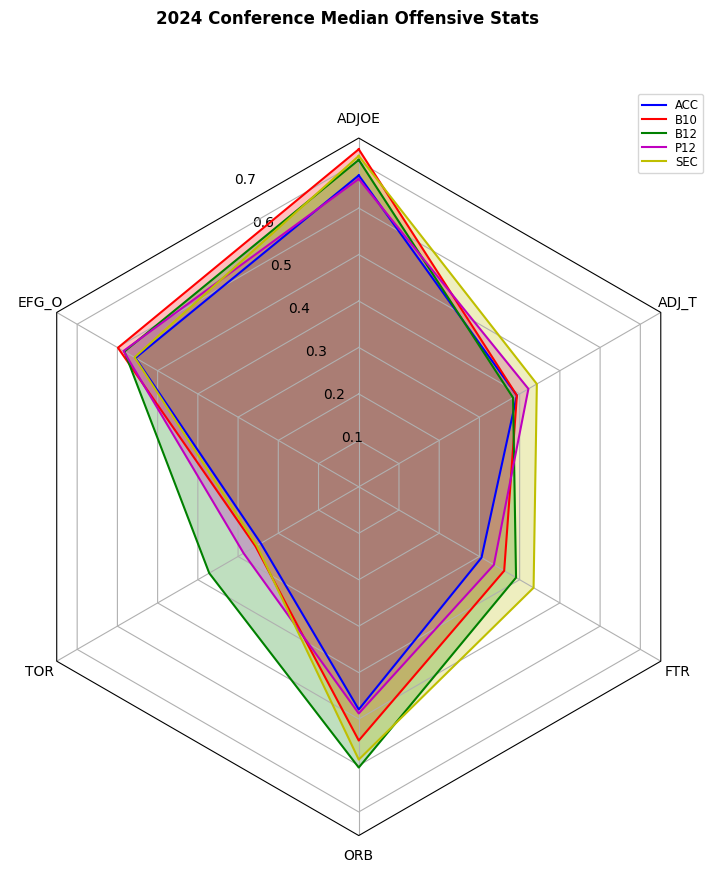

In [14]:
power5 = ['ACC', 'B10', 'B12', 'SEC', 'P12']

data = agg_conf[agg_conf['CONF'].isin(power5)]
radar_graph(data, off_stats, 'CONF', '2024 Conference Median Offensive Stats')

In [15]:
# df['FTR'].max()
df[df['FTR'] > 58]

TEAM  CONF   G  W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D  \
1631  North Carolina A&T  MEAC  31  8   93.1  113.0   0.0975   42.7   50.1   

       TOR  ...  FTRD  2P_O  2P_D  3P_O  3P_D  ADJ_T   WAB  POSTSEASON  SEED  \
1631  22.1  ...  54.4  41.9  47.8  29.5  35.9   67.2 -17.9         NaN   NaN   

      YEAR  
1631  2014  

[1 rows x 24 columns]

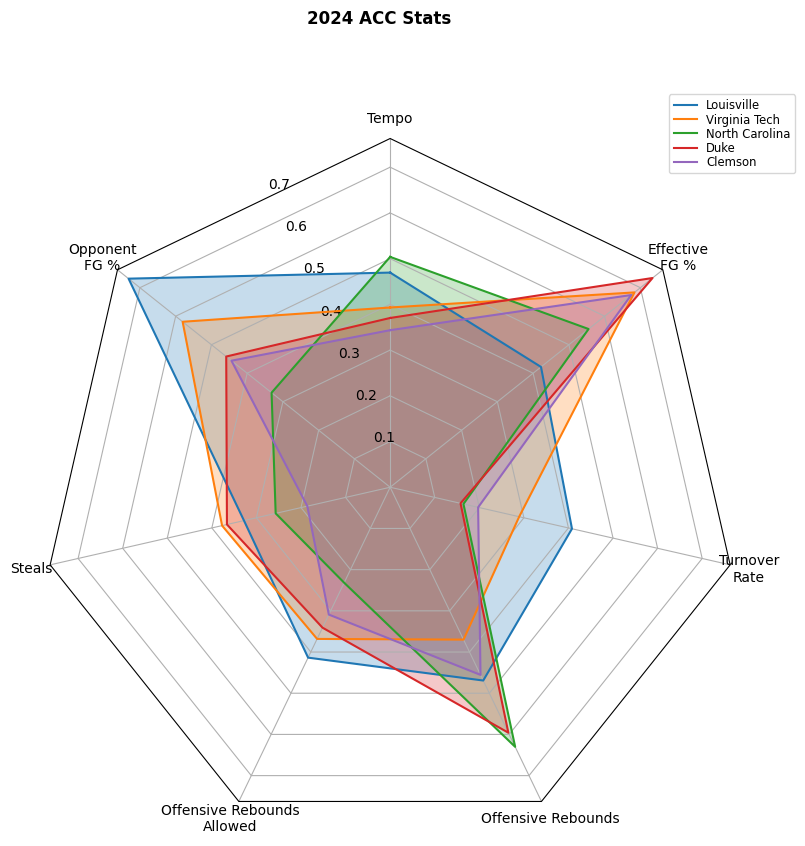

In [189]:
_stats = ["ADJ_T", "EFG_D", "TORD", "DRB", "ORB", "TOR", "EFG_O"]
_labels = ["Tempo", "Opponent\nFG %", "Steals", "Offensive Rebounds\nAllowed", "Offensive Rebounds", "Turnover\nRate", "Effective\nFG %"]
radar_graph(acc_2024.head(), _stats, 'TEAM', '2024 ACC Stats', _labels)

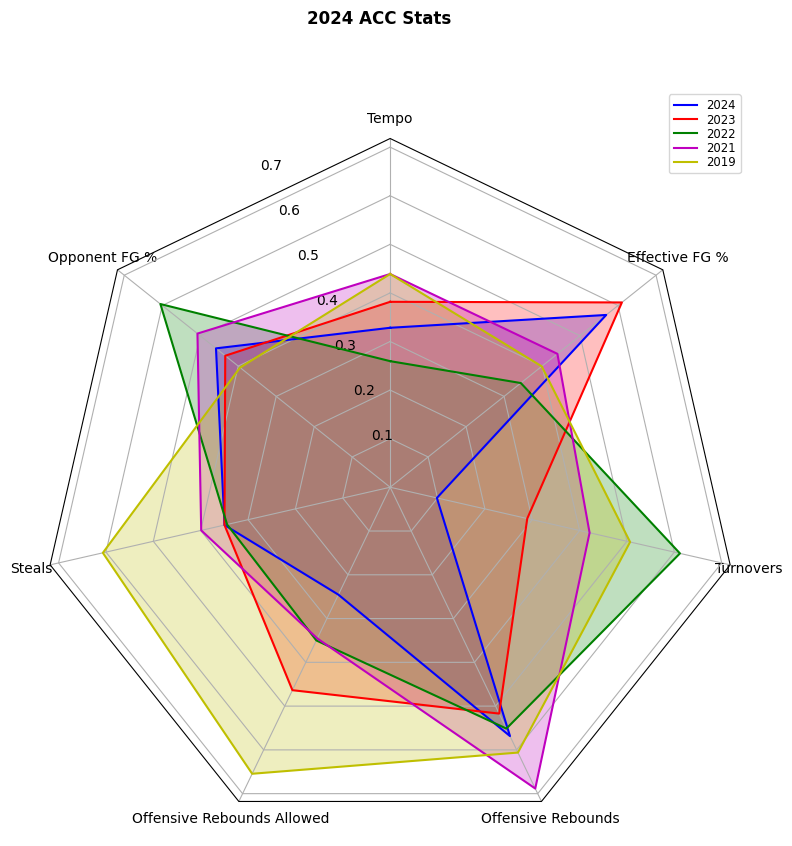

In [44]:
radar_graph((acc[acc['TEAM'] == 'Pittsburgh']).head(), _stats, 'YEAR', '2024 ACC Stats', _labels)

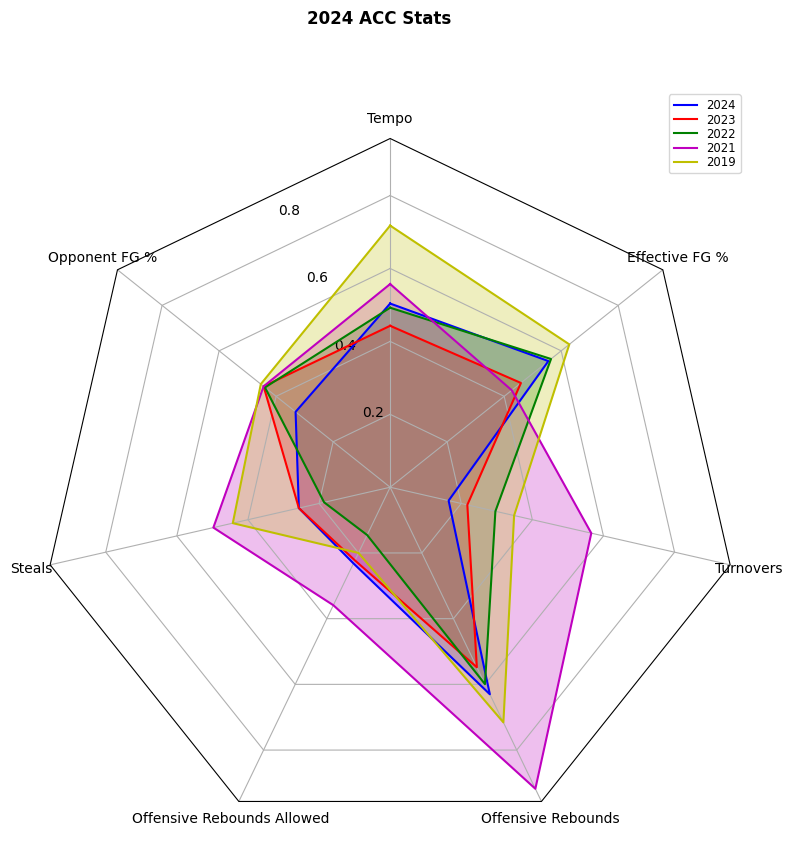

In [45]:
radar_graph(acc[acc['TEAM'] == 'North Carolina'].head(), _stats, 'YEAR', '2024 ACC Stats', _labels)

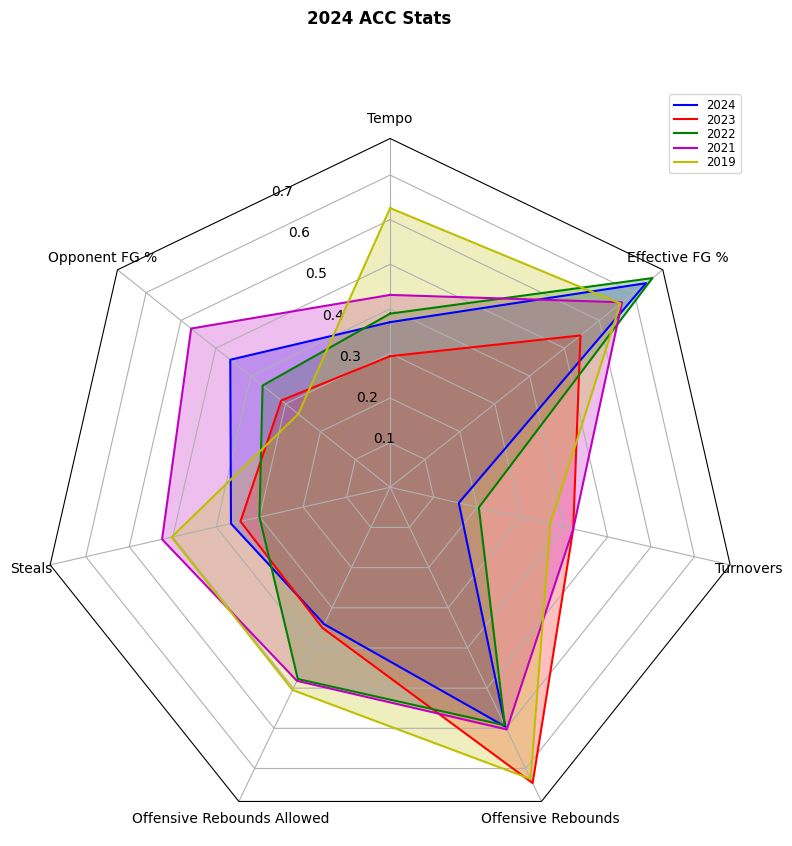

In [46]:
radar_graph(acc[acc['TEAM'] == 'Duke'].head(), _stats, 'YEAR', '2024 ACC Stats', _labels)

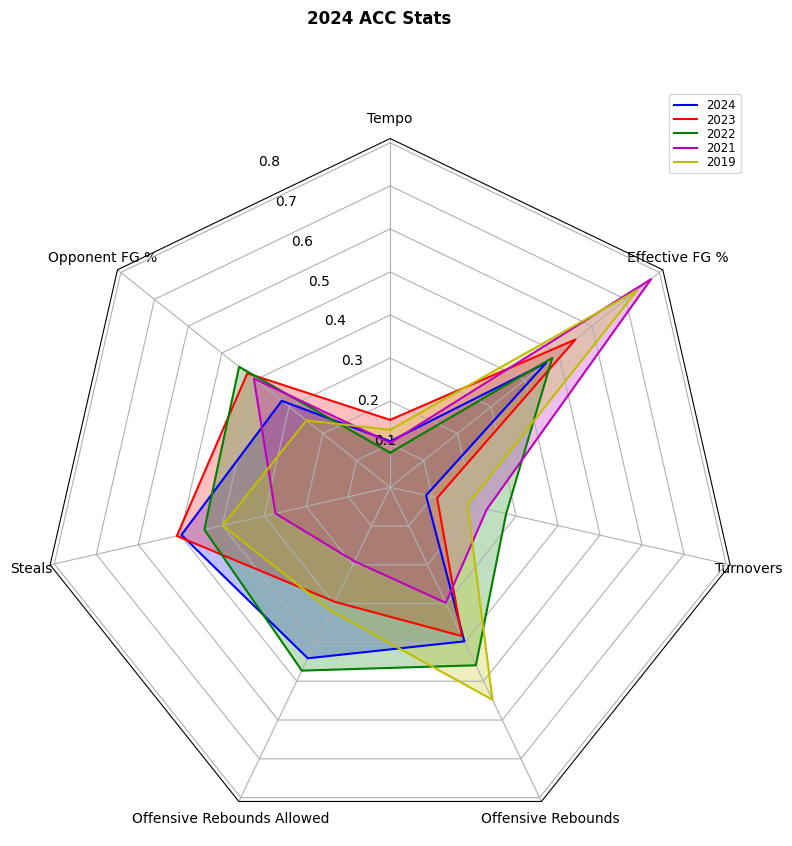

In [ ]:
radar_graph(acc[acc['TEAM'] == 'Virginia'].head(), _stats, 'YEAR', '2024 ACC Stats', _labels)

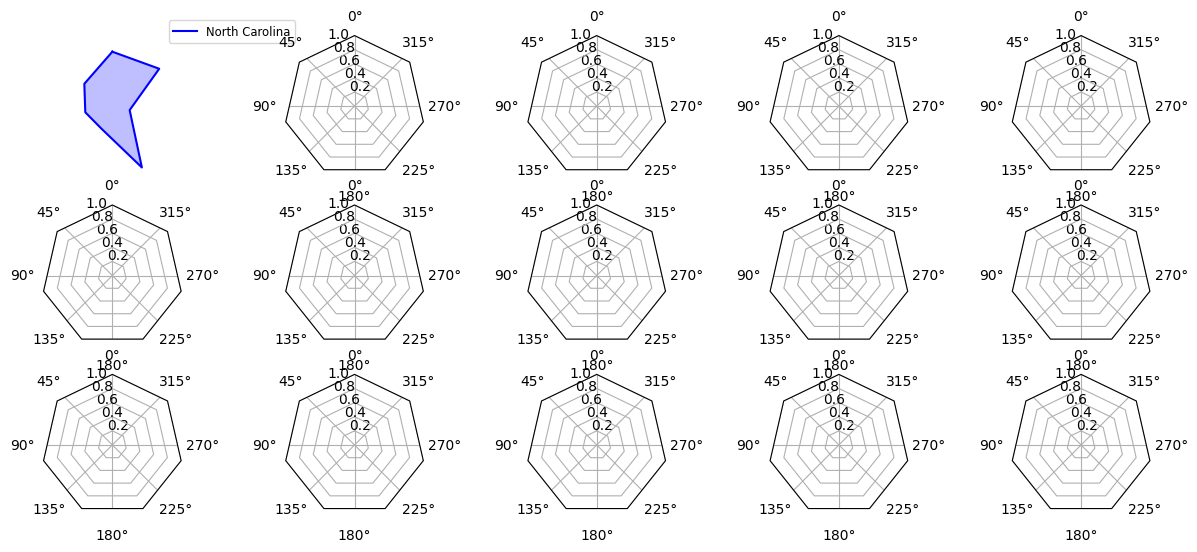

<Figure size 640x480 with 0 Axes>

In [ ]:
# Multi Plot Visual
focus_teams = ["Pittsburgh", "Miami FL", "Duke", "Notre Dame", "Louisville", "Georgia Tech"]
colors = ["#003594", "#F47321", "#003087", "#c99700", "#AD0000", "#B3A369"]
stat = 'WPRCT'
teams = acc["TEAM"].unique()

fig, axes = plt.subplots(3, 5, figsize=(15, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)


SLICES = [(i, j) for i in range(3) for j in range(5)]

i = 0
for slice_ in SLICES:
    ax = axes[slice_]
    ax.set_axis_off()
    focus = teams[i]

    
    radar_graph(acc_2024[acc_2024['TEAM'] == focus], _stats, 'TEAM', '', _labels, ax)

    ax.set_title(focus)
    i+=1


plt.tight_layout()
plt.show()
    

In [67]:
agg_acc

ADJ_T                                    EFG_D         \
                          var median       mean   max   min        var median   
TEAM                                                                            
Boston College      10.316909  67.10  67.390909  72.5  63.2   3.548182   51.5   
Clemson              7.140182  66.20  65.127273  68.0  60.0   4.372727   47.6   
Duke                 5.775636  67.80  68.318182  73.6  64.9   3.878727   47.1   
Florida St.          6.252000  70.00  69.600000  72.8  66.0   6.800545   48.4   
Georgia Tech         1.831636  67.40  67.181818  69.2  64.2   4.554909   49.2   
Louisville           2.990000  67.30  67.866667  70.6  65.6  14.966111   47.0   
Maryland             1.805000  68.15  68.150000  69.1  67.2   6.480000   45.4   
Miami FL            10.552545  67.70  65.963636  68.7  58.7   5.960000   49.0   
North Carolina       3.679636  71.40  71.481818  76.0  68.8   1.690000   48.1   
North Carolina St.   6.874545  68.10  68.863636  72.8  64.7   5.672727   50.5   
Notre Dame           2.082333  65.45  65.730000  68.3  63.9   1.871222   49.2   
Pittsburgh           5.792111  66.40  65.890000  68.7  60.9   2.546778   50.0   
Syracuse             6.992111  67.25  66.790000  70.7  61.5   4.782667   48.3   
Virginia             0.951636  60.50  60.381818  61.9  58.4   4.762545   46.1   
Virginia Tech        6.356909  66.60  66.890909  70.5  63.3   1.823636   50.1   
Wake Forest          2.923636  69.20  69.518182  72.4  66.8   5.312182   50.9   

                                           ...       TOR                    \
                         mean   max   min  ...       var median       mean   
TEAM                                       ...                               
Boston College      51.572727  55.5  48.4  ...  1.661636  18.20  18.218182   
Clemson             47.754545  51.9  43.9  ...  2.680727  17.40  17.345455   
Duke                47.545455  51.3  45.0  ...  2.379636  16.30  16.181818   
Florida St.         49.163636  53.1  45.4  ...  4.262727  18.10  18.954545   
Georgia Tech        48.509091  52.2  45.4  ...  2.812182  18.90  18.327273   
Louisville          48.388889  54.6  44.0  ...  3.266111  17.20  17.788889   
Maryland            45.400000  47.2  43.6  ...  6.480000  20.40  20.400000   
Miami FL            49.500000  52.6  45.7  ...  1.972727  16.80  16.845455   
North Carolina      48.000000  50.1  45.4  ...  2.676727  16.70  16.754545   
North Carolina St.  49.845455  53.4  45.5  ...  3.294545  16.10  16.263636   
Notre Dame          49.630000  52.1  47.9  ...  2.552889  15.00  15.220000   
Pittsburgh          49.530000  52.0  46.7  ...  5.879556  17.55  17.680000   
Syracuse            48.940000  52.8  46.2  ...  2.137889  17.45  17.070000   
Virginia            45.936364  48.8  42.3  ...  2.013636  15.40  15.281818   
Virginia Tech       49.718182  51.5  47.0  ...  1.487636  17.30  17.281818   
Wake Forest         50.772727  54.5  47.3  ...  2.626545  19.20  18.636364   

                                    EFG_O                                
                     max   min        var median       mean   max   min  
TEAM                                                                     
Boston College      20.1  15.5   3.476545  50.80  50.236364  52.7  47.5  
Clemson             19.7  14.9   7.492909  50.70  50.609091  54.1  46.0  
Duke                18.3  14.3   2.242727  53.90  54.354545  56.6  51.1  
Florida St.         22.0  16.4   3.370545  50.50  51.263636  54.4  49.0  
Georgia Tech        21.0  15.6   5.652727  48.50  48.454545  53.9  44.4  
Louisville          22.3  16.0   3.317500  48.80  49.633333  51.9  47.7  
Maryland            22.2  18.6   3.125000  50.35  50.350000  51.6  49.1  
Miami FL            19.5  14.0   5.821636  51.90  51.481818  54.3  47.4  
North Carolina      20.5  14.4   2.192727  51.50  50.954545  52.9  48.5  
North Carolina St.  18.7  13.5   4.254182  51.50  51.172727  54.2  47.9  
Notre Dame          19.1  13.4  11.9093

In [209]:
cmap = plt.get_cmap("tab10")

def agg_formatData(dataframe, input_stats):
    data = []
    for agg in ['max', 'median', 'min']:

        stats = []
        for stat in input_stats:
            stats.append(dataframe[stat][agg])
        data.append(stats)
    return data


""" def normalize(df, val, col):
    return (val - df[col].min())/(df[col].max() - df[col].min()) """


def agg_radar_graph(df, stats, title, labels=None, ax=None):
    N = len(stats)
    theta = radar_factory(N, frame='polygon')

    data = agg_formatData(df, stats)
    if labels is None:
        spoke_labels = stats
    else:
        spoke_labels = labels

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                                subplot_kw=dict(projection='radar'))
        fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
        fig.text(0.5, 0.965, title,
                horizontalalignment='center', color='black', weight='bold',
                size='large')
        # add legend relative to top-left plot
        labels = ['max', 'median', 'min']
        legend = ax.legend(labels, loc=(0.9, .95),
                                    labelspacing=0.1, fontsize='small')
    else:
        ax.set_title(title, fontsize=16, weight='bold')

    # Plot the four cases from the example data on separate Axes
    #for ax, (title, case_data) in zip(axs.flat, data):
        # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    # ax.set_title('ACC Top 5', weight='bold', size='medium', position=(0.5, 1.1),
                    #horizontalalignment='center', verticalalignment='center')
    #print(data)
    for i in range(len(data)):
        ax.plot(theta, data[i], color=cmap(i))
        ax.fill(theta, data[i], facecolor=cmap(i), alpha=0.25, label='_nolegend_')

    ax.set_ylim(0, 1)  # Forces the center to be 0 and the edge to be 1
    
    # Optional: Fix the grid lines at specific intervals (0.2, 0.4, etc.)
    # so the rings don't jump around between plots.
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8], labels=[])
    
    ax.set_varlabels(spoke_labels)


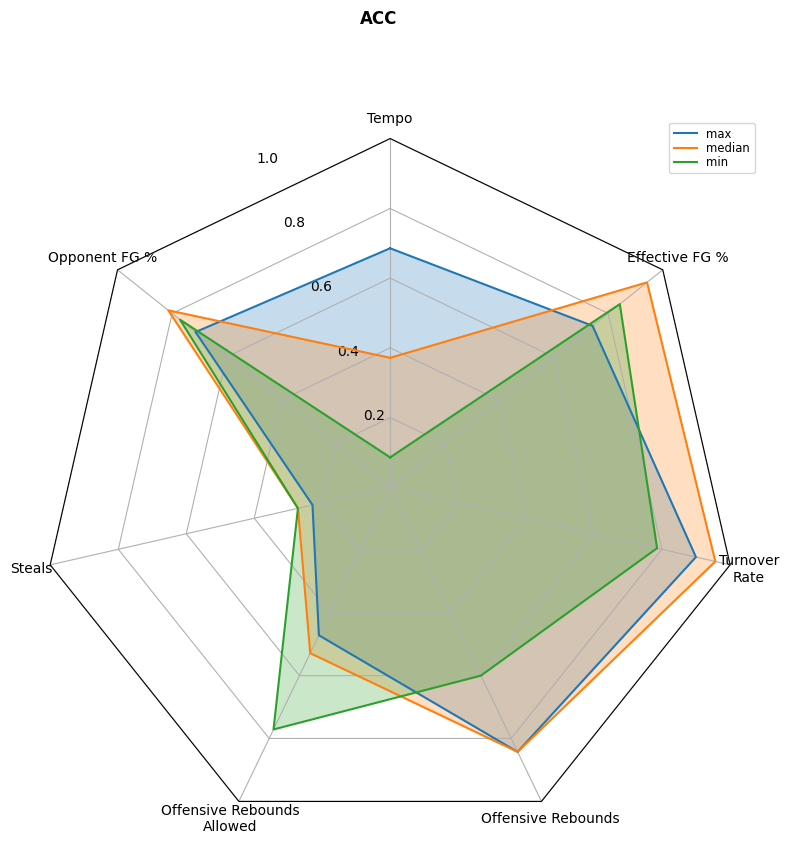

In [172]:
agg_radar_graph(acc_aggregate, _stats, 'ACC', _labels)

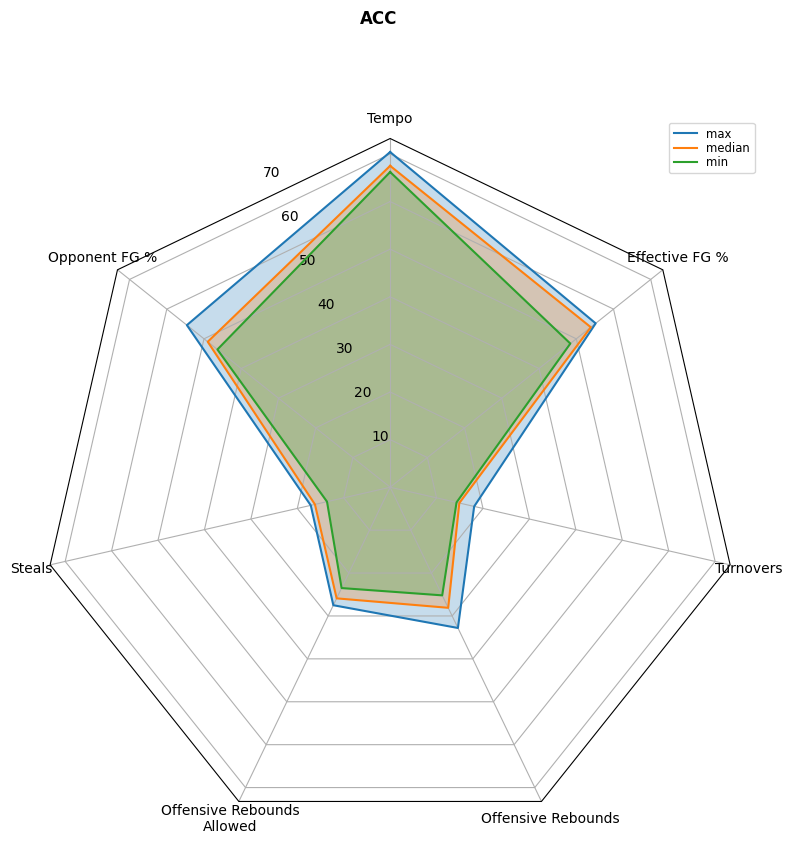

In [126]:
agg_radar_graph(top_team_agg, _stats, 'ACC', _labels)

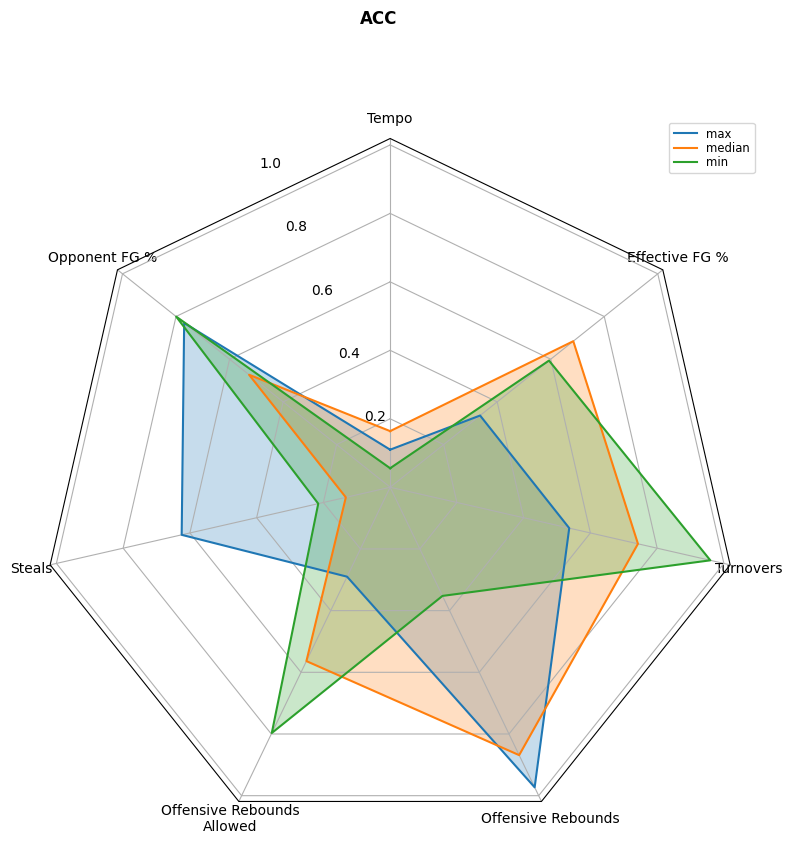

In [161]:
temp = agg_teams.loc['Pittsburgh']
agg_radar_graph(temp, _stats, 'ACC', _labels)

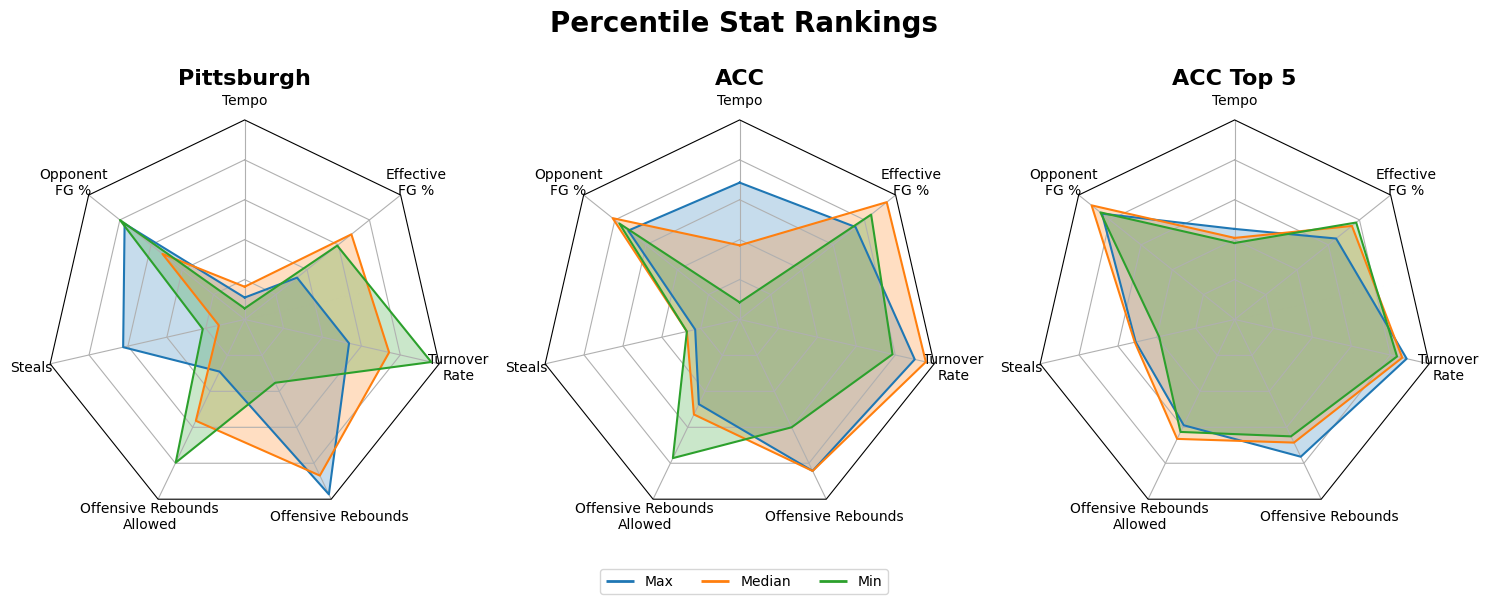

In [217]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

frames = [temp, acc_aggregate, top_team_agg]
titles = ['Pittsburgh', 'ACC', 'ACC Top 5']

for i in range(3):
    ax = axes[i]
    
    agg_radar_graph(frames[i], _stats, titles[i], _labels, ax)

max = mlines.Line2D([], [], color=cmap(0), marker='_', linestyle='None',
                          markersize=20, markeredgewidth=2, label='Max')
median = mlines.Line2D([], [], color=cmap(1), marker='_', linestyle='None',
                          markersize=20, markeredgewidth=2, label='Median')
min = mlines.Line2D([], [], color=cmap(2), marker='_', linestyle='None',
                          markersize=20, markeredgewidth=2, label='Min')
fig.legend(handles=[max, median, min], loc='lower center', fontsize='medium', ncol=3)

fig.suptitle("Percentile Stat Rankings", fontsize=20, weight='bold')

plt.tight_layout()
plt.savefig('radarPlots.svg')
plt.show()

# Original Figure Code Port

In [221]:
def get_color(color):
    if color == "Pittsburgh":
        return "#003594"
    elif color == "Miami FL":
        return "#F47321"
    elif color == "Duke":
        return "#003087"
    elif color == "Notre Dame":
        return "#c99700"
    elif color == "Louisville":
        return "#AD0000"
    elif color == "Georgia Tech":
        return "#B3A369"
    elif color == "Florida St.":
        return "#782F40"
    elif color == "Syracuse":
        return "#F76900"
    elif color == "North Carolina":
        return "#7BAFD4"
    elif color == "North Carolina St.":
        return "#CC0000"
    elif color == "Virginia":
        return "#F84C1E"
    elif color == "Virginia Tech":
        return "#630031"
    elif color == "Wake Forest":
        return "#9E7E38"
    elif color == "Boston College":
        return "#98002E"
    elif color == "Clemson":
        return "#522D80"
    elif color == "Villanova":
        return "#00205b"
    elif color == "Connecticut":
        return "#7C878E"
    elif color == "Baylor":
        return "#154734"
    elif color == "Kansas":
        return "#E8000D"

In [222]:
teams = ["Pittsburgh", "Pittsburgh", "Duke", "North Carolina", "North Carolina St.", "Boston College", "Louisville", "Louisville", "Louisville", "Virginia Tech", "Virginia Tech", "Notre Dame", "Georgia Tech", "Georgia Tech", "Wake Forest"]
years = [2016, 2018, 2022, 2021, 2017, 2021, 2017, 2018, 2022, 2015, 2020, 2023, 2016, 2023, 2021]
coaching_changes = pd.DataFrame()

coaching_changes['TEAM'] = teams
coaching_changes['YEAR'] = years
coaching_changes

TEAM  YEAR
0           Pittsburgh  2016
1           Pittsburgh  2018
2                 Duke  2022
3       North Carolina  2021
4   North Carolina St.  2017
5       Boston College  2021
6           Louisville  2017
7           Louisville  2018
8           Louisville  2022
9        Virginia Tech  2015
10       Virginia Tech  2020
11          Notre Dame  2023
12        Georgia Tech  2016
13        Georgia Tech  2023
14         Wake Forest  2021

In [223]:
path = "./cbb.csv"
df = pd.read_csv(path)
df.head()

TEAM CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D   TOR  \
0  North Carolina  ACC  40  33  123.3   94.9   0.9531   52.6   48.1  15.4   
1       Wisconsin  B10  40  36  129.1   93.6   0.9758   54.8   47.7  12.4   
2        Michigan  B10  40  33  114.4   90.4   0.9375   53.9   47.7  14.0   
3      Texas Tech  B12  38  31  115.2   85.2   0.9696   53.5   43.0  17.7   
4         Gonzaga  WCC  39  37  117.8   86.3   0.9728   56.6   41.1  16.2   

   ...  FTRD  2P_O  2P_D  3P_O  3P_D  ADJ_T   WAB  POSTSEASON  SEED  YEAR  
0  ...  30.4  53.9  44.6  32.7  36.2   71.7   8.6         2ND   1.0  2016  
1  ...  22.4  54.8  44.7  36.5  37.5   59.3  11.3         2ND   1.0  2015  
2  ...  30.0  54.7  46.8  35.2  33.2   65.9   6.9         2ND   3.0  2018  
3  ...  36.6  52.8  41.9  36.5  29.7   67.5   7.0         2ND   3.0  2019  
4  ...  26.9  56.3  40.0  38.2  29.0   71.5   7.7         2ND   1.0  2017  

[5 rows x 24 columns]

In [224]:
# Add win percentage col
df['WPRCT'] = df['W']/df['G']
df

TEAM  CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  \
0             North Carolina   ACC  40  33  123.3   94.9   0.9531   52.6   
1                  Wisconsin   B10  40  36  129.1   93.6   0.9758   54.8   
2                   Michigan   B10  40  33  114.4   90.4   0.9375   53.9   
3                 Texas Tech   B12  38  31  115.2   85.2   0.9696   53.5   
4                    Gonzaga   WCC  39  37  117.8   86.3   0.9728   56.6   
...                      ...   ...  ..  ..    ...    ...      ...    ...   
3880               Stonehill   NEC  30   4   90.3  114.2   0.0629   46.7   
3881          St. Francis PA   NEC  28   8   93.1  118.1   0.0608   47.2   
3882                   IUPUI  Horz  29   6   92.1  116.9   0.0607   46.5   
3883              Coppin St.  MEAC  29   2   85.1  111.1   0.0445   42.1   
3884  Mississippi Valley St.  SWAC  31   1   85.4  116.2   0.0283   42.5   

      EFG_D   TOR  ...  2P_O  2P_D  3P_O  3P_D  ADJ_T   WAB  POSTSEASON  SEED  \
0      48.1  15.4  ...  53.9  44.6  32.7  36.2   71.7   8.6         2ND   1.0   
1      47.7  12.4  ...  54.8  44.7  36.5  37.5   59.3  11.3         2ND   1.0   
2      47.7  14.0  ...  54.7  46.8  35.2  33.2   65.9   6.9         2ND   3.0   
3      43.0  17.7  ...  52.8  41.9  36.5  29.7   67.5   7.0         2ND   3.0   
4      41.1  16.2  ...  56.3  40.0  38.2  29.0   71.5   7.7         2ND   1.0   
...     ...   ...  ...   ...   ...   ...   ...    ...   ...         ...   ...   
3880   52.7  19.5  ...  47.9  51.7  30.1  35.9   68.1 -22.0         NaN   NaN   
3881   53.0  21.2  ...  45.7  52.9  33.2  35.4   65.4 -18.6         NaN   NaN   
3882   58.2  21.3  ...  49.5  59.0  24.7  38.0   67.3 -21.6         NaN   NaN   
3883   51.3  22.9  ...  41.9  51.0  28.3  34.5   66.3 -22.9         NaN   NaN   
3884   55.6  24.0  ...  41.9  55.6  29.2  37.0   64.5 -22.7         NaN   NaN   

      YEAR     WPRCT  
0     2016  0.825000  
1     2015  0.900000  
2     2018  0.825000  
3     2019  0.815789  
4     2017  0.948718  
...    ...       ...  
3880  2024  0.133333  
3881  2024  0.285714  
3882  2024  0.206897  
3883  2024  0.068966  
3884  2024  0.032258  

[3885 rows x 25 columns]

In [225]:
acc = df[df['CONF'] == 'ACC']
acc = acc[acc['TEAM'] != 'Maryland']
acc.head()

TEAM CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D   TOR  \
0   North Carolina  ACC  40  33  123.3   94.9   0.9531   52.6   48.1  15.4   
7             Duke  ACC  39  35  125.2   90.6   0.9764   56.6   46.5  16.3   
8         Virginia  ACC  38  35  123.0   89.9   0.9736   55.2   44.7  14.7   
9   North Carolina  ACC  39  33  121.0   91.5   0.9615   51.7   48.1  16.2   
14      Louisville  ACC  36  27  109.4   87.4   0.9290   47.7   44.0  17.2   

    ...  2P_O  2P_D  3P_O  3P_D  ADJ_T   WAB  POSTSEASON  SEED  YEAR     WPRCT  
0   ...  53.9  44.6  32.7  36.2   71.7   8.6         2ND   1.0  2016  0.825000  
7   ...  55.9  46.3  38.7  31.4   66.4  10.7   Champions   1.0  2015  0.897436  
8   ...  52.5  45.7  39.5  28.9   60.7  11.1   Champions   1.0  2019  0.921053  
9   ...  51.0  46.3  35.5  33.9   72.8   8.4   Champions   1.0  2017  0.846154  
14  ...  48.4  43.3  30.7  30.3   65.6   5.8          E8   4.0  2015  0.750000  

[5 rows x 25 columns]

In [226]:
teams = acc["TEAM"].unique()
teams

array(['North Carolina', 'Duke', 'Virginia', 'Louisville', 'Notre Dame',
       'Florida St.', 'Syracuse', 'Boston College', 'Clemson',
       'Georgia Tech', 'Miami FL', 'Pittsburgh', 'Virginia Tech',
       'Wake Forest', 'North Carolina St.'], dtype=object)

In [227]:
# Delta BARTHAG or other stat
stat = 'BARTHAG'
vars = []


teams = acc["TEAM"].unique()
for team in teams:
    team_stats = acc[acc['TEAM'] == team]
    vars.append(team_stats[stat].max() - team_stats[stat].min())

df_stat_var = pd.DataFrame({'TEAM' : teams, 
                            stat : vars})

acc_ordered_mean = df_stat_var.sort_values('BARTHAG', ascending=True)

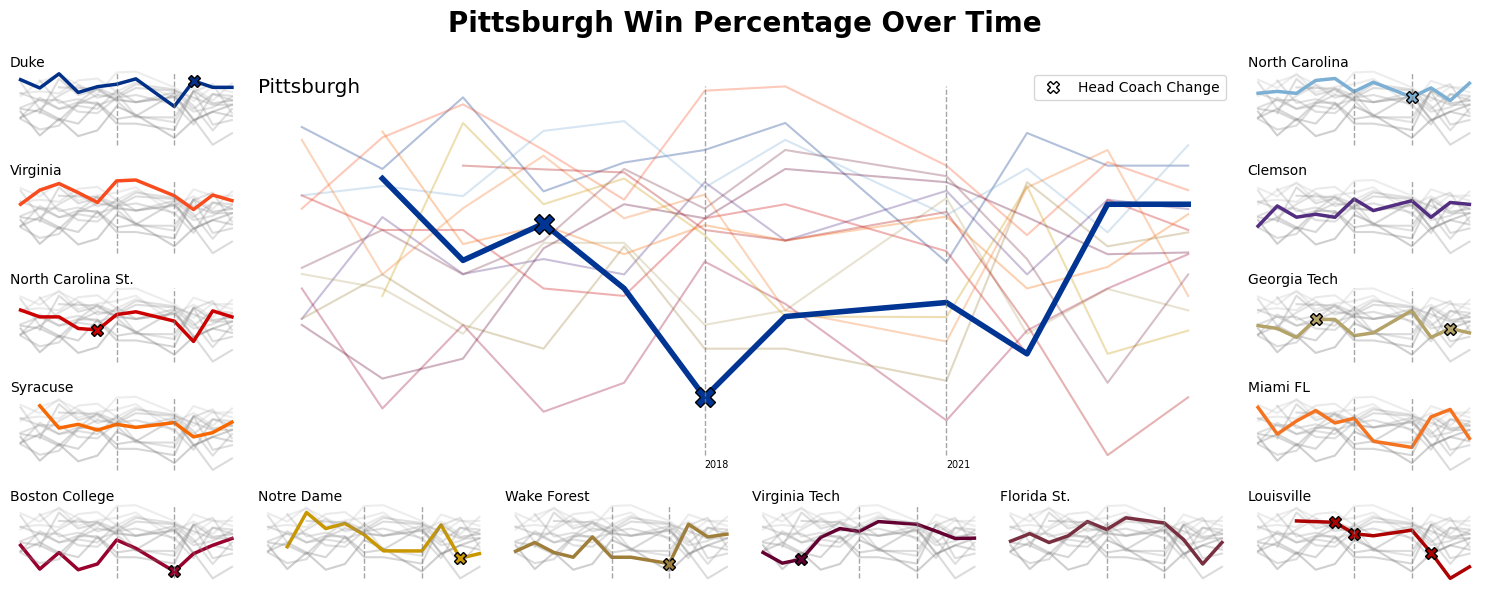

In [234]:
# Multi Plot Visual
focus_teams = ["Pittsburgh", "Miami FL", "Duke", "Notre Dame", "Louisville", "Georgia Tech"]
center_team = "Pittsburgh"
colors = ["#003594", "#F47321", "#003087", "#c99700", "#AD0000", "#B3A369"]
stat = 'WPRCT'
# teams = acc["TEAM"].unique()

# Left to right, top to bottom teams are ordered by difference between max and min power rating
teams = acc_ordered_mean[acc_ordered_mean["TEAM"] != center_team]['TEAM'].unique()
# teams = ["Miami FL", "North Carolina", "North Carolina St.", "Florida St.", "Boston College", "Virginia", "Pittsburgh", "Louisville", "Wake Forest", "Virginia Tech", "Syracuse", "Georgia Tech", "Notre Dame", "Duke", "Clemson"]
# teams = ["Duke", "North Carolina", "Virginia", "Virginia Tech", "Miami FL", "Wake Forest", "Boston College", "Notre Dame", "North Carolina St.", "Pittsburgh", "Clemson", "Syracuse", "Georgia Tech", "Florida St.", "Louisville"]

fig = plt.figure(figsize=(15, 6))

gs = GridSpec(5, 12, figure=fig)

# SLICES = [(i, j) for i in range(3) for j in range(5)]

k = 0
for i in range(4):
    for j in range(2):
        ax = fig.add_subplot(gs[i, j*10:j*10+2])
        ax.set_axis_off()
        cmap = plt.colormaps['gray']            

        
        focus = teams[k]

        for team in teams:
            team_stats = acc[acc['TEAM'] == team]
            team_stats = team_stats.sort_values('YEAR')
            x = team_stats['YEAR']
            y = team_stats[stat]
            if team != focus:
                ax.plot(x, y, alpha=0.3, color=cmap(team_stats[stat].mean()))

        team_stats = acc[acc['TEAM'] == focus]
        team_stats = team_stats.sort_values('YEAR')
        x = team_stats['YEAR']
        y = team_stats[stat]
        ax.plot(x, y, label = focus, alpha=1, color=get_color(focus), lw=2.5)

        focus_coaches = coaching_changes[coaching_changes['TEAM'] == focus]
        
        for year in focus_coaches['YEAR']:
            team_stats = acc[acc['TEAM'] == focus]
            for index, row in team_stats.iterrows():
                    if row['YEAR'] == year:
                        x = row['YEAR']
                        y = row[stat]
                        ax.plot(x, y, marker='X', color=get_color(focus), markeredgecolor='black', ms=8)
        
        ax.set_title(focus, fontsize='medium', loc='left', y=0.92)
        bot, top = ax.get_ylim()
        ax.axvline(2018, color="gray", linestyle="--", linewidth=1, alpha=0.7, ymin=(acc[stat].min()-bot)/(top-bot), ymax=(acc[stat].max()-bot)/(top-bot))
        ax.axvline(2021, color="gray", linestyle="--", linewidth=1, alpha=0.7, ymin=(acc[stat].min()-bot)/(top-bot), ymax=(acc[stat].max()-bot)/(top-bot))
        k+=1


""" axes = []
axes.append(fig.add_subplot(gs[3, 1:3]))
axes.append(fig.add_subplot(gs[3, 3:5]))
axes.append(fig.add_subplot(gs[3, 5:7])) """

for i in range(6):
    ax = fig.add_subplot(gs[4, i*2:i*2+2])
    ax.set_axis_off()
    cmap = plt.colormaps['gray']
    if k >= 15:
        for team in teams:
            team_stats = acc[acc['TEAM'] == team]
            team_stats = team_stats.sort_values('YEAR')
            x = team_stats['YEAR']
            y = team_stats[stat]
            ax.plot(x, y, alpha=0.3, color=cmap(team_stats[stat].mean()))
            ax.annotate("2018", xy=(2018, 0.1), fontsize='xx-small')
            ax.annotate("2021", xy=(2021, 0.1), fontsize='xx-small')
    else: 
        focus = teams[k]

        for team in teams:
            team_stats = acc[acc['TEAM'] == team]
            team_stats = team_stats.sort_values('YEAR')
            x = team_stats['YEAR']
            y = team_stats[stat]
            if team == focus:
                ax.plot(x, y, label = team, alpha=1, color=get_color(team), lw=2.5)
            else:
                ax.plot(x, y, alpha=0.3, color=cmap(team_stats[stat].mean()))

        focus_coaches = coaching_changes[coaching_changes['TEAM'] == focus]
        
        for year in focus_coaches['YEAR']:
            team_stats = acc[acc['TEAM'] == focus]
            for index, row in team_stats.iterrows():
                    if row['YEAR'] == year:
                        x = row['YEAR']
                        y = row[stat]
                        ax.plot(x, y, marker='X', color=get_color(focus), markeredgecolor='black', ms=8)
        
        ax.set_title(focus, fontsize='medium', loc='left', y=0.92)
    bot, top = ax.get_ylim()
    ax.axvline(2018, color="gray", linestyle="--", linewidth=1, alpha=0.7, ymin=(acc[stat].min()-bot)/(top-bot), ymax=(acc[stat].max()-bot)/(top-bot))
    ax.axvline(2021, color="gray", linestyle="--", linewidth=1, alpha=0.7, ymin=(acc[stat].min()-bot)/(top-bot), ymax=(acc[stat].max()-bot)/(top-bot))
    k+=1


# Print Main Figure
ax = fig.add_subplot(gs[0:4, 2:10])
ax.set_axis_off()
cmap = plt.colormaps['gray']            


focus = center_team

for team in teams:
    team_stats = acc[acc['TEAM'] == team]
    team_stats = team_stats.sort_values('YEAR')
    x = team_stats['YEAR']
    y = team_stats[stat]
    #ax.plot(x, y, alpha=0.3, color=cmap(team_stats[stat].mean()))
    ax.plot(x, y, alpha=0.3, color=get_color(team))

team_stats = acc[acc['TEAM'] == focus]
team_stats = team_stats.sort_values('YEAR')
x = team_stats['YEAR']
y = team_stats[stat]
ax.plot(x, y, label = focus, alpha=1, color=get_color(focus), lw=4)

focus_coaches = coaching_changes[coaching_changes['TEAM'] == focus]

for year in focus_coaches['YEAR']:
    team_stats = acc[acc['TEAM'] == focus]
    for index, row in team_stats.iterrows():
            if row['YEAR'] == year:
                x = row['YEAR']
                y = row[stat]
                ax.plot(x, y, marker='X', color=get_color(focus), markeredgecolor='black', ms=15)

ax.set_title(focus, fontsize='x-large', loc='left', y=0.92)
bot, top = ax.get_ylim()
ax.axvline(2018, color="gray", linestyle="--", linewidth=1, alpha=0.7, ymin=(acc[stat].min()-bot)/(top-bot), ymax=(acc[stat].max()-bot)/(top-bot))
ax.axvline(2021, color="gray", linestyle="--", linewidth=1, alpha=0.7, ymin=(acc[stat].min()-bot)/(top-bot), ymax=(acc[stat].max()-bot)/(top-bot))
ax.annotate("2018", xy=(2018, 0.1), fontsize='x-small')
ax.annotate("2021", xy=(2021, 0.1), fontsize='x-small')


cross = mlines.Line2D([], [], color='white', marker='X', linestyle='None',
                          markersize=8, markeredgecolor='black', label='Head Coach Change')
ax.legend(handles=[cross], loc='upper right', fontsize='medium')

fig.suptitle(center_team + ' Win Percentage Over Time', fontsize=20, weight='bold')

plt.tight_layout()
plt.savefig('finalMainColor.svg')
plt.show()

# Combined Figure Attempt

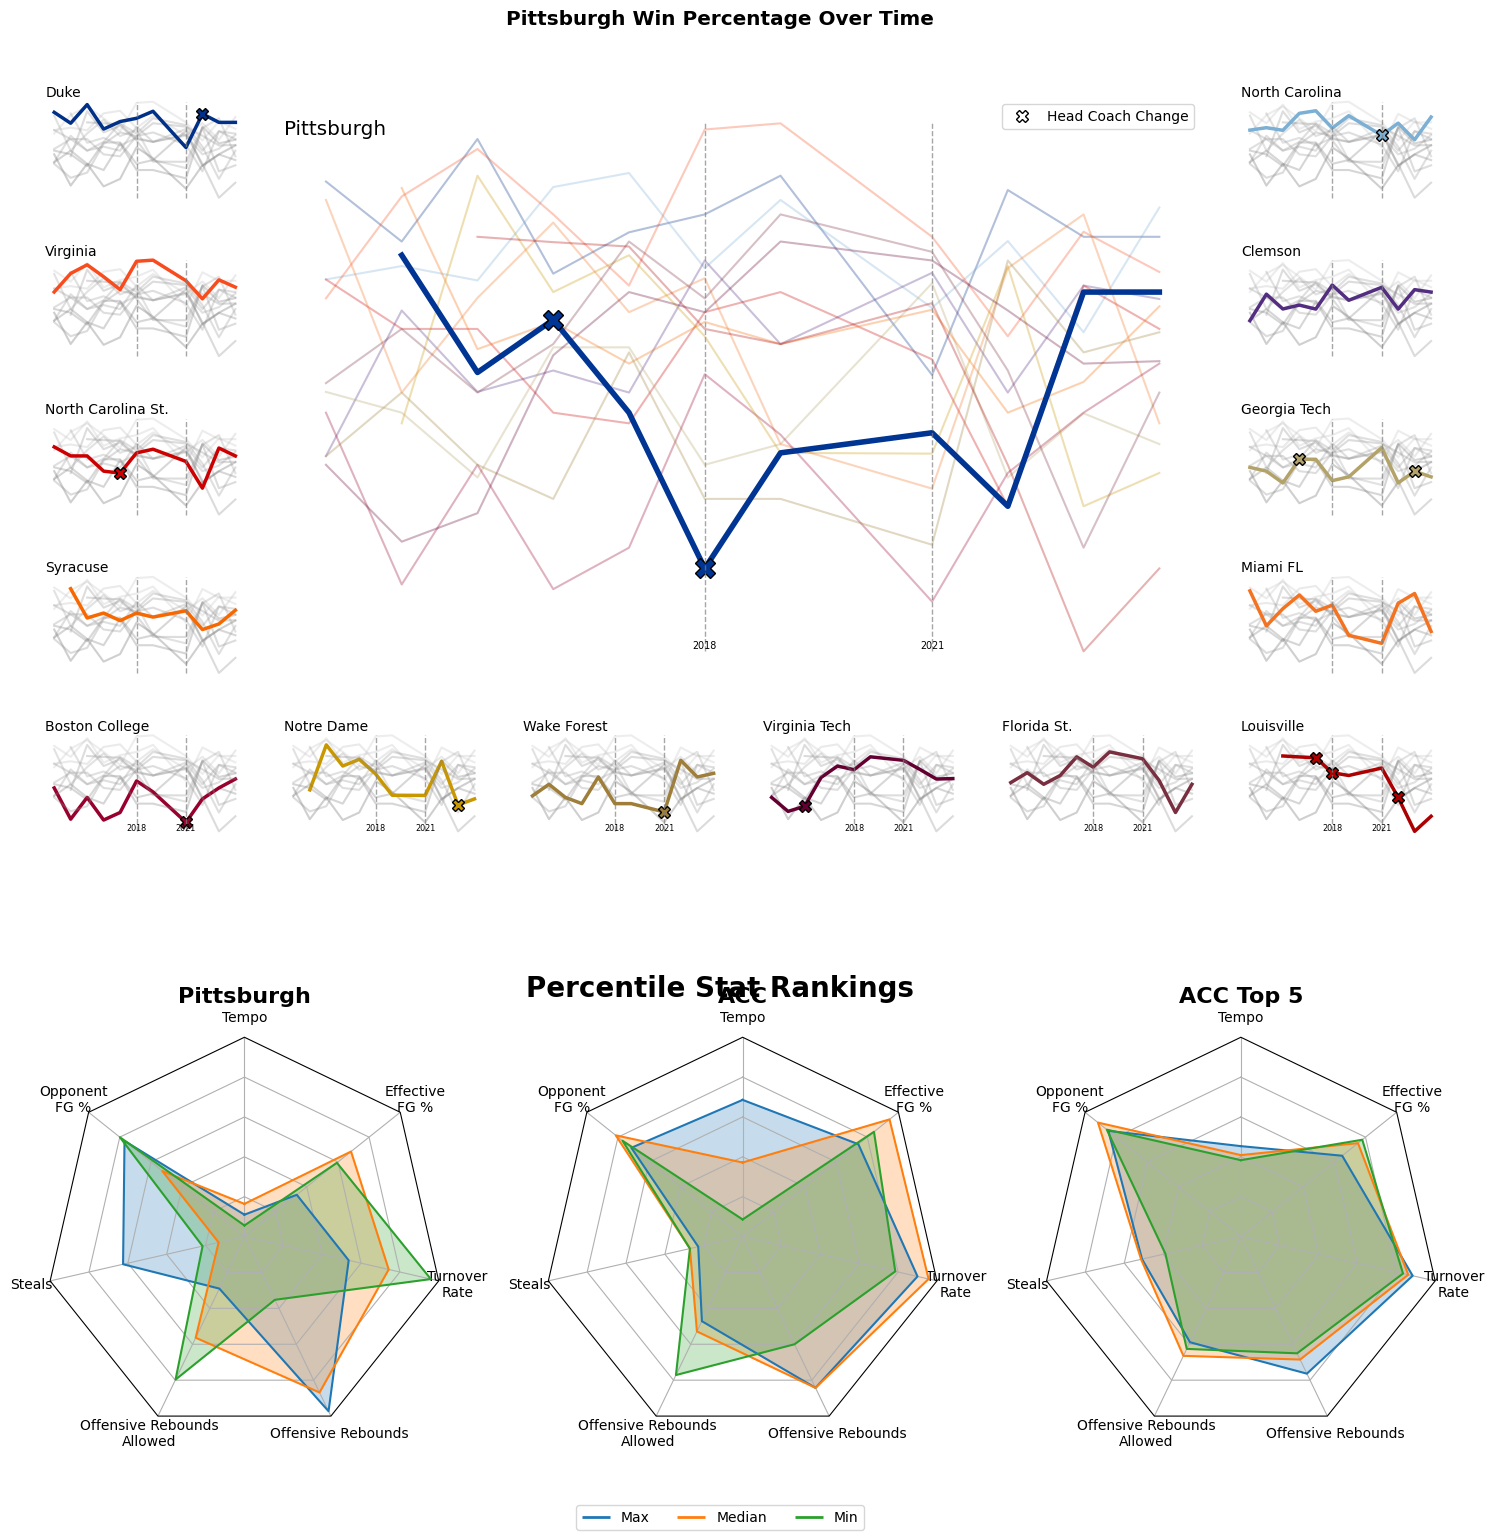

In [232]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines

# 1. Setup the combined figure
# Increased height to accommodate both sections (Time Series on Top, Radar on Bottom)
fig = plt.figure(figsize=(18, 18)) 

# Create an outer GridSpec with 2 rows.
# Row 0 (Top): Time Series (Allocating 60% of height)
# Row 1 (Bottom): Radar Charts (Allocating 40% of height)
outer_gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[0.6, 0.4], hspace=0.25)

# ==========================================
# PART 1: Top Section - Time Series (Win %)
# ==========================================

# Create a nested GridSpec for the top layout (5 rows, 12 columns)
gs_top = gridspec.GridSpecFromSubplotSpec(5, 12, subplot_spec=outer_gs[0], wspace=0.5, hspace=0.5)

# Settings for Time Series
stat = 'WPRCT'
center_team = "Pittsburgh"

# Define the order of teams (filtering out the center team)
# If acc_ordered_mean is not defined, we calculate the order by variable range (Max - Min)
try:
    teams_list = acc_ordered_mean[acc_ordered_mean["TEAM"] != center_team]['TEAM'].unique()
except NameError:
    # Fallback: Order by difference between Max and Min WPRCT (dynamic ranking)
    diff = acc.groupby('TEAM')[stat].agg(lambda x: x.max() - x.min()).sort_values(ascending=False)
    teams_list = [t for t in diff.index if t != center_team]

k = 0
cmap_gray = plt.colormaps['gray']

# --- Small Plots (Top 4 rows of the grid, skipping the center area) ---
for i in range(4):
    for j in range(2):
        if k >= len(teams_list): break
        
        # Add subplot to the specific slot in gs_top
        ax = fig.add_subplot(gs_top[i, j*10:j*10+2]) 
        ax.set_axis_off()
        
        focus = teams_list[k]

        # Background lines for other teams
        for team in teams_list:
            team_stats = acc[acc['TEAM'] == team].sort_values('YEAR')
            if team != focus:
                ax.plot(team_stats['YEAR'], team_stats[stat], alpha=0.3, color=cmap_gray(team_stats[stat].mean()))

        # Highlight focus team
        team_stats = acc[acc['TEAM'] == focus].sort_values('YEAR')
        ax.plot(team_stats['YEAR'], team_stats[stat], label=focus, alpha=1, color=get_color(focus), lw=2.5)

        # Mark coaching changes
        focus_coaches = coaching_changes[coaching_changes['TEAM'] == focus]
        for year in focus_coaches['YEAR']:
            year_stat = team_stats[team_stats['YEAR'] == year]
            if not year_stat.empty:
                ax.plot(year, year_stat[stat].values[0], marker='X', color=get_color(focus), markeredgecolor='black', ms=8)
        
        ax.set_title(focus, fontsize='medium', loc='left', y=0.92)
        
        # Vertical Reference Lines (2018, 2021)
        bot, top = ax.get_ylim()
        for year in [2018, 2021]:
            ax.axvline(year, color="gray", linestyle="--", linewidth=1, alpha=0.7, 
                       ymin=(acc[stat].min()-bot)/(top-bot), ymax=(acc[stat].max()-bot)/(top-bot))
        k += 1

# --- Small Plots (Bottom Row of the grid) ---
for i in range(6):
    ax = fig.add_subplot(gs_top[4, i*2:i*2+2])
    ax.set_axis_off()
    
    if k >= len(teams_list):
        # Remaining spots (if any)
        for team in teams_list:
            team_stats = acc[acc['TEAM'] == team].sort_values('YEAR')
            ax.plot(team_stats['YEAR'], team_stats[stat], alpha=0.3, color=cmap_gray(team_stats[stat].mean()))
    else: 
        focus = teams_list[k]
        for team in teams_list:
            team_stats = acc[acc['TEAM'] == team].sort_values('YEAR')
            if team == focus:
                ax.plot(team_stats['YEAR'], team_stats[stat], label=team, alpha=1, color=get_color(team), lw=2.5)
            else:
                ax.plot(team_stats['YEAR'], team_stats[stat], alpha=0.3, color=cmap_gray(team_stats[stat].mean()))

        focus_coaches = coaching_changes[coaching_changes['TEAM'] == focus]
        for year in focus_coaches['YEAR']:
            team_stats = acc[acc['TEAM'] == focus]
            match = team_stats[team_stats['YEAR'] == year]
            if not match.empty:
                ax.plot(year, match[stat].values[0], marker='X', color=get_color(focus), markeredgecolor='black', ms=8)
        
        ax.set_title(focus, fontsize='medium', loc='left', y=0.92)
    
    # Vertical lines and labels for the bottom row
    bot, top = ax.get_ylim()
    for year in [2018, 2021]:
        ax.axvline(year, color="gray", linestyle="--", linewidth=1, alpha=0.7, 
                   ymin=(acc[stat].min()-bot)/(top-bot), ymax=(acc[stat].max()-bot)/(top-bot))
        ax.annotate(str(year), xy=(year, bot + (top-bot)*0.05), fontsize='xx-small', ha='center')
    k += 1

# --- Main Center Plot ---
ax_main = fig.add_subplot(gs_top[0:4, 2:10])
ax_main.set_axis_off()

focus = center_team
for team in teams_list:
    team_stats = acc[acc['TEAM'] == team].sort_values('YEAR')
    ax_main.plot(team_stats['YEAR'], team_stats[stat], alpha=0.3, color=get_color(team))

# Highlight Main Team
team_stats = acc[acc['TEAM'] == focus].sort_values('YEAR')
ax_main.plot(team_stats['YEAR'], team_stats[stat], label=focus, alpha=1, color=get_color(focus), lw=4)

focus_coaches = coaching_changes[coaching_changes['TEAM'] == focus]
for year in focus_coaches['YEAR']:
    match = team_stats[team_stats['YEAR'] == year]
    if not match.empty:
        ax_main.plot(year, match[stat].values[0], marker='X', color=get_color(focus), markeredgecolor='black', ms=15)

ax_main.set_title(focus, fontsize='x-large', loc='left', y=0.92)

# Main Plot Annotations
bot, top = ax_main.get_ylim()
for year in [2018, 2021]:
    ax_main.axvline(year, color="gray", linestyle="--", linewidth=1, alpha=0.7, 
                    ymin=(acc[stat].min()-bot)/(top-bot), ymax=(acc[stat].max()-bot)/(top-bot))
    ax_main.annotate(str(year), xy=(year, bot + (top-bot)*0.05), fontsize='x-small', ha='center')

# Legend for Top Section
cross = mlines.Line2D([], [], color='white', marker='X', linestyle='None',
                      markersize=8, markeredgecolor='black', label='Head Coach Change')
ax_main.legend(handles=[cross], loc='upper right', fontsize='medium')

fig.text(0.5, 0.92, center_team + ' Win Percentage Over Time', fontsize='x-large', ha='center', weight='bold')


# ==========================================
# PART 2: Bottom Section - Radar Charts
# ==========================================

# Create a nested GridSpec for the 3 radar charts
gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[1], wspace=0.25)
cmap = plt.get_cmap("tab10")

# Frames and titles for the radar charts
frames = [temp, acc_aggregate, top_team_agg]
titles = ['Pittsburgh', 'ACC', 'ACC Top 5']

# Check if radar_factory needs to be called to get theta (or if it's handled in agg_radar_graph)
# Assuming agg_radar_graph handles the plotting but we need to setup the axes with projection='radar'

for i in range(3):
    ax = fig.add_subplot(gs_bottom[0, i], projection='radar')
    # Call your existing function to plot on the specific axis `ax`
    agg_radar_graph(frames[i], _stats, titles[i], _labels, ax)

# Legend for Radar Charts
cmap_radar = plt.get_cmap("tab10")
max_line = mlines.Line2D([], [], color=cmap_radar(0), marker='_', linestyle='None', 
                         markersize=20, markeredgewidth=2, label='Max')
median_line = mlines.Line2D([], [], color=cmap_radar(1), marker='_', linestyle='None', 
                            markersize=20, markeredgewidth=2, label='Median')
min_line = mlines.Line2D([], [], color=cmap_radar(2), marker='_', linestyle='None', 
                         markersize=20, markeredgewidth=2, label='Min')

# Place legend for the bottom section
fig.legend(handles=[max_line, median_line, min_line], loc='lower center', 
           bbox_to_anchor=(0.5, 0.08), fontsize='medium', ncol=3)

# Title for Bottom Section
fig.text(0.5, 0.38, "Percentile Stat Rankings", fontsize=20, weight='bold', ha='center')

# Save and Show
plt.savefig('combined_figure_v2.svg', bbox_inches='tight')
plt.show()